# Simple Statistical Analysis Of Data

In [13]:
# Import requirements

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

In [14]:
# Load the data from the CSV file
data = pd.read_csv('transformed_data.csv', encoding='ISO-8859-1')

display(data)

,sample_id,file_id,wl_code,poco,tipo_amostra,direcao_amostra,numero_testo,profundidade,porosidade,densidade,...,curva,coeficiente_litologico,coeficiente_cimentacao,expoente_saturacao,unidade,fluxo_fracionario,permeabilidade_fluido_deslocante,permeabilidade_fluido_deslocado,kg_abs,saturacao_agua
0,102,6031766.0,WL000564736,Well A,A,VH1,NaN,2028.0,2.3,2.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105,6031766.0,WL000564736,Well A,A,VH1,NaN,2035.0,20.2,2.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,6031766.0,WL000564736,Well A,A,VH1,NaN,2038.0,20.7,2.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,103,6031766.0,WL000564736,Well A,A,VH1,NaN,2050.0,22.5,2.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106,6031766.0,WL000564736,Well A,A,VH1,NaN,2052.0,17.7,2.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1503,6037915.0,WL000774024,Well Z,Amostra Lateral,VH1,-,4750.0,22.4,2.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2515,1504,6037915.0,WL000774024,Well Z,Amostra Lateral,VH1,-,4751.0,15.7,2.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2516,1505,6037915.0,WL000774024,Well Z,Amostra Lateral,VH1,-,4752.0,19.8,2.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2517,1506,6037915.0,WL000774024,Well Z,Amostra Lateral,VH1,-,4755.0,8.2,2.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visual Errors

1. Some values are impossibly large. ie 500000m deep. 
2. Some values don't fall within the physical boundaries of the measurment
3. There are global anomalies and local anomalies that could be explain by human or equiptment failure
4. Column titles are repeated half-way through
5. Characters have accents and may not have the same local encoding
6. Decimals and commas are used interchangably. It should be standardised to decimals.

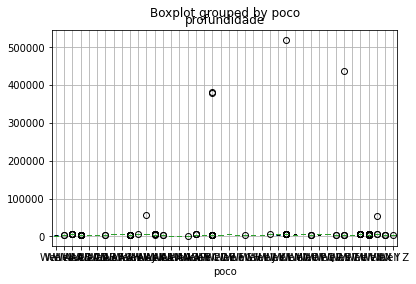

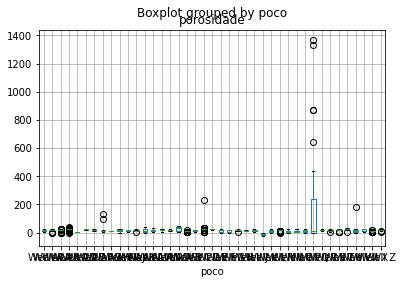

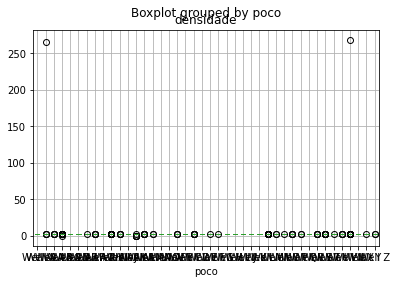

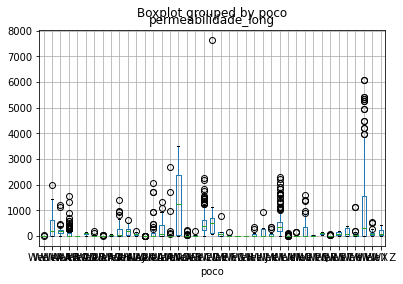

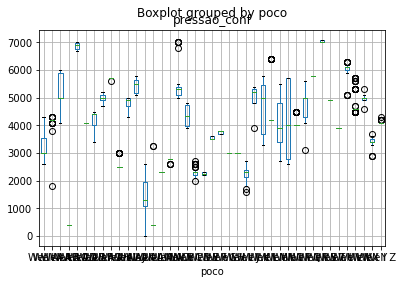

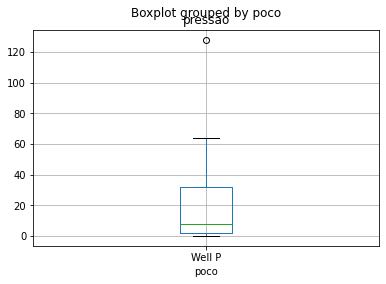

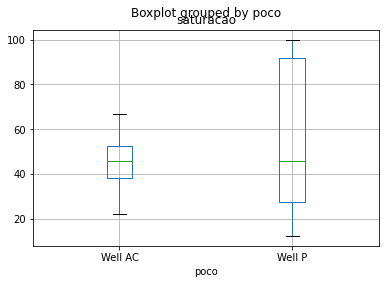

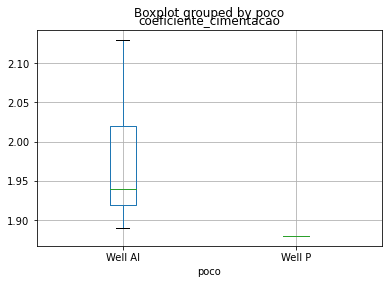

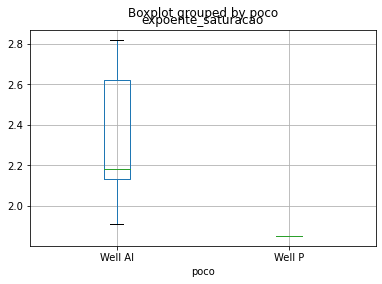

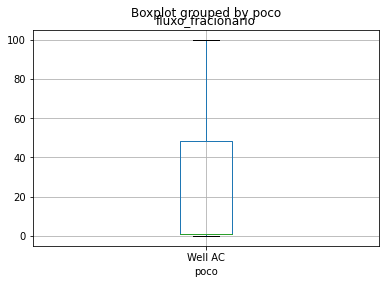

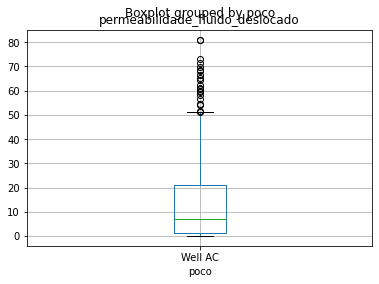

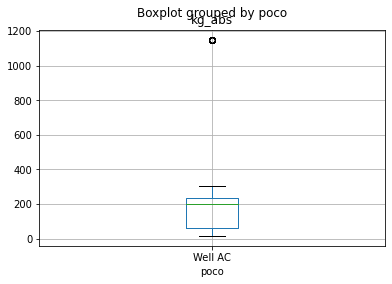

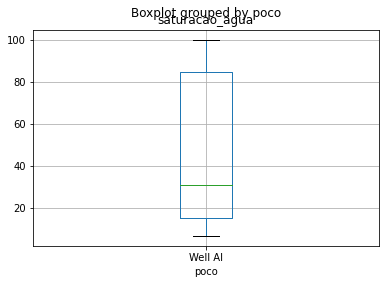

In [15]:
# Using boxplot to locate errors

# Select the columns for the box plot
columns = ['profundidade', 'porosidade', 'densidade', 'permeabilidade_long', 
           'pressao_conf', 'pressao', 'saturacao', 'coeficiente_cimentacao', 
           'expoente_saturacao', 'fluxo_fracionario', 'permeabilidade_fluido_deslocado', 
           'kg_abs', 'saturacao_agua']

# Convert the columns to float, excluding non-numeric values
data[columns] = data[columns].apply(pd.to_numeric, errors='coerce')
# Iterate through each column (except "poco") and create a boxplot
data[columns] = data[columns].astype(float)

# Iterate through each column (except "poco") and create a boxplot
for name in columns:
    if name != 'poco':
        mask = data[name].notna()
        filtered_df = data.loc[mask]
        filtered_df.boxplot(column=name, by='poco')

# Show the plot
plt.show()

In [16]:
# A function to include decimal places if left out. Also fixes negative values

# Create value ranges for certain columns.
def add_decimal(val, name):
    '''
    Returns the corrected value with either a decimal or absolute value

            Parameters:
                    name (str): The name of the column in the dataframe
                    val (float): Value that is being checked

            Returns:
                    val (float): The corrected value
    '''
    if name == 'profundidade':
        if val > 100000:
            return val / 100
        elif val < 100000 and val > 10000:
            return val / 10
        elif val < 0:
            max(val, 0)
        else:
            return val
    elif name == 'porosidade':
        if val > 100:
            return val / 100
        return max(min(val, 1), 0)
    elif name == 'densidade':
        if val > 200:
            return val / 100
        else:
            return val
    return val

In [17]:
# A function to check value ranges for each numerical column with data

def check_boundaries(val, name):
    '''
    Returns the corrected value after checking the current value against the boundaries.
    If the boundaries are broken, the add_decimal function is used to see if it is
    one of the special cases of input error

            Parameters:
                    name (str): The name of the column in the dataframe
                    val (float): Value that is being checked

            Returns:
                    val (float): The corrected value
    '''
    # Define upper and lower bounds for each column
    bounds = {
        'profundidade': {'lower': 0, 'upper': 50000},
        'porosidade': {'lower': 0, 'upper': 100},
        'densidade': {'lower': 0, 'upper': 200},
        'permeabilidade_long': {'lower': 0, 'upper': 10000},
        'pressao_conf': {'lower': 0, 'upper': 10000},
        'pressao': {'lower': 0, 'upper': 500},
        'saturacao': {'lower': 0, 'upper': 100},
        'coeficiente_cimentacao': {'lower': 0, 'upper': 100},
        'expoente_saturacao': {'lower': 0, 'upper': 10},
        'fluxo_fracionario': {'lower': 0, 'upper': 100},
        'permeabilidade_fluido_deslocado': {'lower': 0, 'upper': 10000},
        'kg_abs': {'lower': 0, 'upper': 1500},
        'saturacao_agua': {'lower': 0, 'upper': 100}
    }
    # Check if value is out of bounds and correct it if necessary
    if val < bounds[name]['lower']:
        print(f"The value has changed to {val} because it is less than 0")
        return abs(val)
    elif val > bounds[name]['upper']:
        new_bound = bounds[name]['upper']
        old_val = val
        val = add_decimal(val, name)
        print(f"The value has changed to {val} from {old_val} because it is greater than {new_bound}")
        return val
    else:
        return val

# Apply the functions to minimise large errors

As you can see, 'profundidade', 'porosidade' and 'densidade' show the largest anomalies. These are in the form of negative values, extremly large values and values equalling 0

The value has changed to 5615.9 from 56159.0 because it is greater than 50000
The value has changed to 3796.13 from 379613.0 because it is greater than 50000
The value has changed to 3812.97 from 381297.0 because it is greater than 50000
The value has changed to 5201.15 from 520115.0 because it is greater than 50000
The value has changed to 4361.71 from 436171.0 because it is greater than 50000
The value has changed to 5250.5 from 52505.0 because it is greater than 50000
The value has changed to 1.35 from 135.0 because it is greater than 100
The value has changed to 2.33 from 233.0 because it is greater than 100
The value has changed to -24.3 because it is less than 0
The value has changed to -5.3 because it is less than 0
The value has changed to -9.7 because it is less than 0
The value has changed to -4.5 because it is less than 0
The value has changed to -21.9 because it is less than 0
The value has changed to -2.0 because it is less than 0
The value has changed to -2.5 because it i

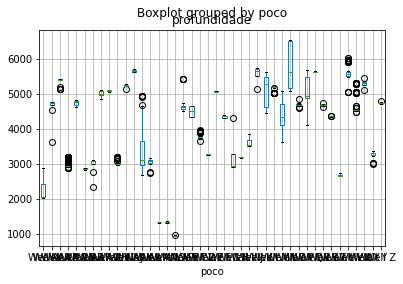

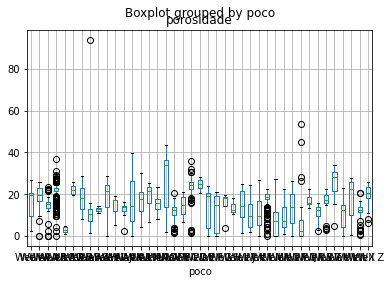

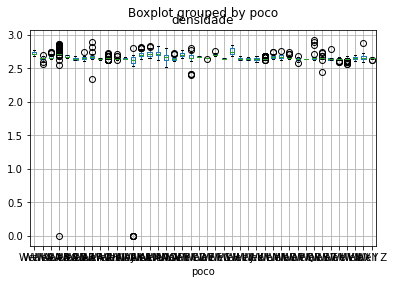

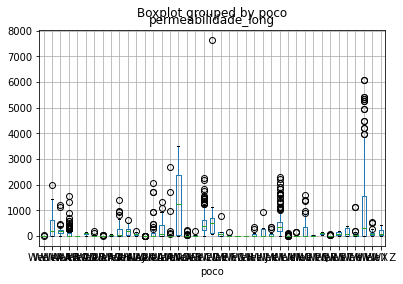

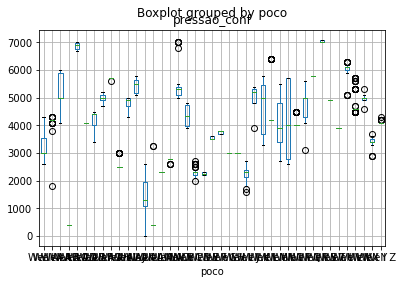

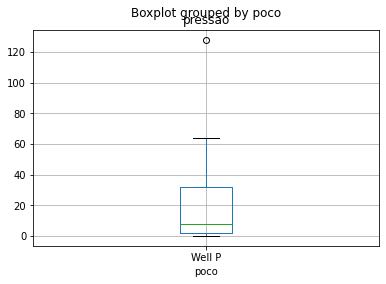

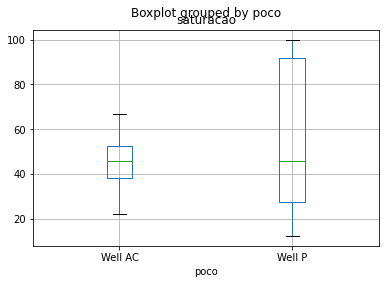

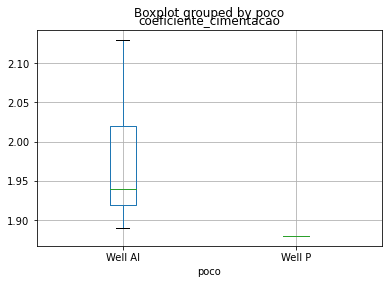

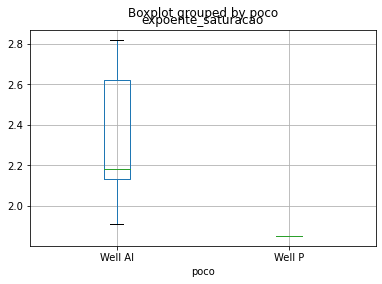

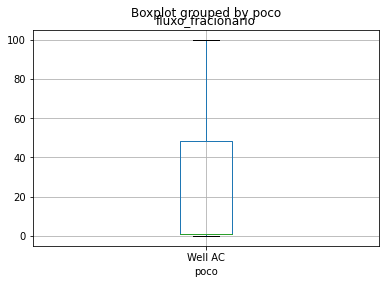

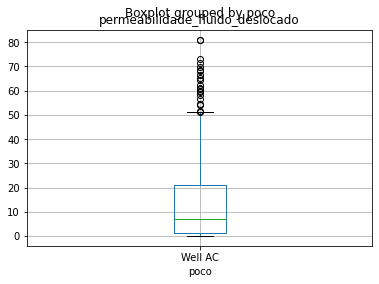

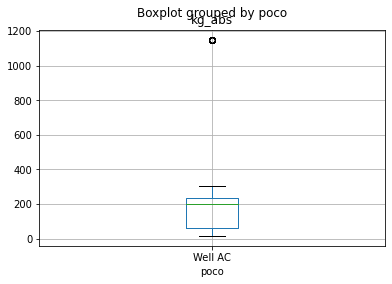

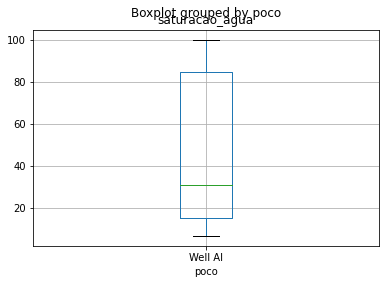

In [18]:
# Apply the check_boundaries function and re-print the data

for df_c in columns:
    data[df_c] = data[df_c].apply(check_boundaries, name = df_c)

# Iterate through each column (except "poco") and create a boxplot
for name in columns:
    if name != 'poco':
        mask = data[name].notna()
        filtered_df = data.loc[mask]
        filtered_df.boxplot(column=name, by='poco')

# Show the plot
plt.show()

Once we have sorted out the aggregious anomalies, we can use any data that is greater than 3 standard deviations to see if there are any more errors

In [19]:
# Function to find both global and local anomalies (local being the well name)

def find_global_anomalies(column_name):
    '''
    Returns the global anomalies that are greater than 3 standard deviations

            Parameters:
                    column_name (str): The name of the column in the dataframe

            Returns:
                    anomalies (series): A pandas series with the anomalis indexed
    '''
    # Calculate the mean and standard deviation of your data
    mean = data[column_name].mean()
    std = data[column_name].std()

    # Create a boolean mask to select the values that are more than three standard deviations away from the mean
    mask = (data[column_name] > mean + 3*std) | (data[column_name] < mean - 3*std)

    # Use the boolean mask to select the rows with anomalous values
    anomalies = data[mask]

def find_local_anomalies(column_name):
    '''
    Returns the local anomalies that are greater than 3 standard deviations for each poco in the given column

            Parameters:
                    column_name (str): The name of the column in the dataframe

            Returns:
                    anomalies (dataframe): A pandas dataframe with the anomalous values and their respective pocos indexed
    '''
    # Group the data by "poco" and calculate the mean and standard deviation for each group
    grouped_data = data.groupby('poco')[column_name].agg(['mean', 'std']).reset_index()

    # Merge the grouped data back into the original data frame
    data_with_means = data.merge(grouped_data, on='poco', suffixes=('', '_group'))

    # Create a boolean mask to select the values that are more than three standard deviations away from the group means
    mask = (data_with_means[column_name] > data_with_means['mean'] + 
        3*data_with_means['std']) | (data_with_means[column_name] < data_with_means['mean'] - 3*data_with_means['std'])

    # Use the boolean mask to select the rows with anomalous values and return a dataframe with the anomalous values and their respective pocos indexed
    anomalies = data_with_means[mask][['poco', column_name]].set_index('poco')
    return anomalies


In [20]:
for df_c in columns:
    print(find_global_anomalies(df_c))

None
None
None
None
None
None
None
None
None
None
None
None
None


In [21]:
for df_c in columns:
    print(find_local_anomalies(df_c))

         profundidade
poco                 
Well AA        3614.0
Well AC        3112.0
Well AC        3121.5
Well AC        3125.0
Well AC        3129.6
Well AC        3136.0
Well AC        3141.0
Well AC        3144.6
Well AC        3153.2
Well AC        3155.2
Well AC        3165.3
Well AC        3168.0
Well AC        3171.0
Well AC        3176.6
Well AC        3180.1
Well AC        3183.8
Well AC        3186.7
Well AC        3190.0
Well AC        3192.0
Well AC        3195.0
Well AC        3198.9
Well AC        3202.0
Well AI        3138.0
Well AI        3149.4
Well AI        3156.0
Well AI        3165.0
Well AI        3176.0
Well AI        3187.0
Well AI        3190.0
Well AI        3193.2
Well AJ        5147.0
Well AM        2742.0
Well AM        2755.5
Well B         5408.0
Well B         5409.6
Well B         5412.8
Well B         5417.5
Well D         3645.0
Well D         3915.5
Well D         3915.5
Well D         3918.0
Well D         3923.7
Well D         3924.0
Well D    

In [22]:
# write the transformed data to a new file
data.to_csv('final_transformation.csv', index=False, encoding='latin-1')

display(data)

# Final Anlaysis

1. We were able to remove global errors from the dataset. Only left with local errors

The local error that are left can be further analysed visually from the dataset. It can be seen that these errors mainly come about because of two techniques -  Amostra Lateral and  Amostra Plug are used on the same well. This The different techniques seem to provide slightly different results so it may be prudent to seperate the data into two seperate files. Furthermore, it is apparent that wells AI and AC have more local errors than other wells. When reveiwing the csv file, it is apparent that the datasets is seperated from standard data and extra data such as the weight of the core. However, the number of rows don't add up so I didn't take it upon myself to merge these two peices of data. There is no way to match that data and the normal Well AC data since the depth stays stagnant and it is apparent that the file_id and sample_id does not display uniqueness. 